In [2]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

warnings.filterwarnings('ignore')

# Import data 

In [3]:
df = pd.read_csv('../data/row/inputs.csv').drop(columns=['freq', 'valor_negociacao'])
df

,porte,media_cenario,frequencia,valor_pessimista,media,valor_otimo,valor_otimista
0,0,863.286180,351,984.0,1100.0,1168.5,1230.0
1,1,1736.081757,171,1920.0,2110.0,2232.5,2350.0
2,2,2264.830895,670,2380.0,2490.0,2490.0,2600.0
3,3,2675.373872,1743,2680.0,2750.0,2750.0,2830.0
4,4,4328.934812,1556,4280.0,4360.0,4360.0,4440.0
5,6,5267.513943,1296,5410.0,5530.0,5530.0,5650.0
6,7,9666.323543,273,9250.0,9840.0,9880.0,10400.0


# Definindo o Problema

In [4]:
class ModelingProblem(ElementwiseProblem):
    def __init__(self, target_lower, target_upper, xl_input, xu_input, media_cenario, frequencia):
        self.target_lower = target_lower
        self.target_upper = target_upper
        self.xl_input = xl_input
        self.xu_input = xu_input
        self.media_cenario = media_cenario 
        self.frequencia = frequencia
        self.alpha = 1
    
        super().__init__(
            n_var = 7, 
            n_obj = 2,
            n_constr = 2, 
            xl = xl_input, 
            xu = xu_input
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = sum((self.media_cenario - x) * self.frequencia)
        f2 = np.std(1/self.frequencia * x * self.alpha)
        
        g1 = self.target_lower - sum(x * self.frequencia)
        g2 = sum(x * self.frequencia) - self.target_upper

        out['F'] = [f1, f2]
        out['G'] = [g1, g2]

# Executar otimização

In [5]:
problem = ModelingProblem(
    24000000,
    24500000,
    df.valor_pessimista.to_numpy(),
    df.valor_otimista.to_numpy(),
    df.media_cenario.to_numpy(),
    df.frequencia.to_numpy()
) 

nsga2 = NSGA2(
    pop_size = 100,
    n_offsprings = 70,
    eliminate_duplicates=True
)

res_nsga2 = minimize(
    problem,
    nsga2,
    get_termination("n_gen", 200),
    seed=1,
    save_history=True,
    verbose=False,
)

res_x = res_nsga2.X   
res_f = res_nsga2.F
res_hist = res_nsga2.history


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



# salvar as soluções

In [6]:
def save_solutions(dataframe, solution, save = False, output = None):
    size = len(solution)
    for i in range(size):
        dataframe[f'solution_{i}'] = solution[i]
        
    if save == True:        
        dataframe.to_csv('data/solutions/'+output, index=False)
        
    return dataframe

In [7]:
df_solutions = save_solutions(df.drop(columns=['media_cenario']), res_x)
df_solutions

,porte,frequencia,valor_pessimista,media,valor_otimo,valor_otimista,solution_0,solution_1,solution_2,solution_3,...,solution_90,solution_91,solution_92,solution_93,solution_94,solution_95,solution_96,solution_97,solution_98,solution_99
0,0,351,984.0,1100.0,1168.5,1230.0,1229.999217,1229.999396,1229.998907,1229.997211,...,1229.999789,1229.999438,1229.999718,1229.991224,1229.999227,1229.999328,1229.998952,1229.999758,1229.996890,1229.999226
1,1,171,1920.0,2110.0,2232.5,2350.0,1920.113990,2333.728531,2348.499937,2348.799991,...,2346.780108,2331.333127,2013.193228,2349.593739,2347.469831,2347.352248,2349.550366,2340.482948,2343.425606,1937.805004
2,2,670,2380.0,2490.0,2490.0,2600.0,2599.999809,2599.999558,2599.999948,2599.998195,...,2599.999988,2599.999668,2599.999730,2599.999997,2599.999527,2599.999809,2599.998247,2599.998703,2599.994680,2599.999804
3,3,1743,2680.0,2750.0,2750.0,2830.0,2829.999798,2829.999311,2829.999997,2829.999553,...,2829.999804,2829.998770,2829.999794,2829.999955,2829.999802,2829.999902,2829.999745,2829.999997,2829.998917,2829.999986
4,4,1556,4280.0,4360.0,4360.0,4440.0,4439.999761,4439.998725,4439.999438,4439.999927,...,4439.999809,4439.994997,4439.997898,4439.999957,4439.999845,4439.999927,4439.998068,4439.813544,4439.909542,4439.999761
5,6,1296,5410.0,5530.0,5530.0,5650.0,5649.999975,5649.999933,5649.999041,5649.999967,...,5649.999082,5648.642824,5649.999826,5649.999805,5649.999802,5649.999975,5649.999993,5649.999970,5649.999967,5649.999972
6,7,273,9250.0,9840.0,9880.0,10400.0,9250.006193,10122.556742,9555.394734,9589.561608,...,9869.652860,9250.057082,9250.955095,10003.182850,9451.040708,9518.941089,9668.974500,9865.811796,9474.055989,9251.669632


# Filtrar os resultados

- Buscar Soluções onde os porte 7 mais diminuiu

In [8]:
def smaller_sizes(df_solutions, portes=[7], total_solutions=30):
    df_solutions = df_solutions.drop(
        columns=[
            'frequencia', 
            'valor_pessimista', 
            'media',
            'valor_otimo',
            'valor_otimista',
        ]
    )
    
    aux = df_solutions[df_solutions.porte.isin(portes)]
    df = pd.DataFrame()
    df['solutions'] = aux.columns[1:]
    
    if aux.shape[0] == 0:
        df[f'porte_{portes[0]}'] = aux.values[0][1:]
        df[f'porte_{portes[1]}'] = aux.values[1][1:]
    
    if aux.shape[0] == 1:
        df[f'porte_{portes[0]}'] = aux.values[0][1:]
                
    return df.nsmallest(total_solutions, columns=df.columns[1:], keep='first')

In [9]:
filtro_portes = smaller_sizes(df_solutions)
filtro_portes

,solutions,porte_7
25,solution_25,9250.001386
0,solution_0,9250.006193
46,solution_46,9250.006193
85,solution_85,9250.009420
57,solution_57,9250.057082
91,solution_91,9250.057082
13,solution_13,9250.256448
33,solution_33,9250.301490
6,solution_6,9250.393665
92,solution_92,9250.955095


- Pegar as soluções com maior receita

In [10]:
def receive_solutions(df_solutions, solutions_selected, frequencia=df.frequencia, total_solutions=15):    
    receita = [sum(df_solutions[solutions_selected][s] * frequencia) for s in solutions_selected]
    
    df = pd.DataFrame(columns=['solutions', 'receita'])
    df['solutions'] = solutions_selected
    df['receita'] = receita  
    
    return df.sort_values(by=['receita'], ascending=False).head(total_solutions)

In [11]:
maiores_receitas = receive_solutions(df_solutions, filtro_portes.solutions)
maiores_receitas

,solutions,receita
17,solution_17,2.430147e+07
9,solution_9,2.429741e+07
35,solution_35,2.429421e+07
60,solution_60,2.429213e+07
14,solution_14,2.428663e+07
74,solution_74,2.428503e+07
66,solution_66,2.428373e+07
29,solution_29,2.427785e+07
59,solution_59,2.427500e+07
37,solution_37,2.427369e+07


- Com as maiores receitas, verifique as cinco menores diferenças positivas das soluções em relação aos valores otimos

In [12]:
def dif_receita(max_receive, great_value=df.valor_otimo, freq=df.frequencia, n=5):
    max_receive['dif_receitas'] = max_receive.receita - sum(great_value * freq)
    return max_receive.nsmallest(n, columns='dif_receitas', keep='first')

In [13]:
filtro_dif_receita = dif_receita(maiores_receitas)
filtro_dif_receita

,solutions,receita,dif_receitas
13,solution_13,2.425283e+07,351102.300185
46,solution_46,2.425710e+07,355372.675845
91,solution_91,2.425961e+07,357883.299739
67,solution_67,2.426419e+07,362457.793148
24,solution_24,2.426855e+07,366823.502695


In [14]:
cols = np.append(filtro_dif_receita.solutions, 'porte')
df_solutions[cols]

,solution_13,solution_46,solution_91,solution_67,solution_24,porte
0,1229.996753,1229.999217,1229.999438,1229.983145,1229.999730,0
1,2281.023760,2306.391322,2331.333127,2344.121004,2327.010492,1
2,2599.999801,2599.999806,2599.999668,2599.999772,2599.982358,2
3,2829.999824,2829.999798,2829.998770,2829.999730,2829.998880,3
4,4439.999961,4439.999912,4439.994997,4439.998730,4439.999424,4
5,5649.999897,5649.999972,5648.642824,5649.999674,5649.999829,6
6,9250.256448,9250.006193,9250.057082,9252.355452,9279.086793,7


- Diferença dos portes menos os valores otimistas dos portes 

In [15]:
def dif_portes(df_solutions, max_receive, great_value=df.valor_otimo):
    
    solutions = max_receive['solutions'].values
    cols = np.append(solutions, "porte")
    aux = df_solutions[cols]
    
    df = pd.DataFrame()
    df['portes'] = aux.porte
    
    for i in solutions:
        df[i] = aux[i] - great_value
    
    df = df[df.columns[1:]].T
    df = df.reset_index()

    df.columns = [
        'solutions','dif_porte_0', 
        'dif_porte_1', 'dif_porte_2', 
        'dif_porte_3', 'dif_porte_4', 
        'dif_porte_6','dif_porte_7'
    ]
    
    df['total'] = df.iloc[:, 1:].sum(axis = 1)
    return df

In [16]:
df_dif_portes = dif_portes(df_solutions, maiores_receitas)

In [17]:
# cinco "melhores" soluções para o negocio porque matematicamente é tudo a mesma coisa
filtro_dif_portes = df_dif_portes.nsmallest(5, columns='total', keep='first')
filtro_dif_portes

,solutions,dif_porte_0,dif_porte_1,dif_porte_2,dif_porte_3,dif_porte_4,dif_porte_6,dif_porte_7,total
14,solution_13,61.496753,48.523760,109.999801,79.999824,79.999961,119.999897,-629.743552,-129.723556
13,solution_46,61.499217,73.891322,109.999806,79.999798,79.999912,119.999972,-629.993807,-104.603781
12,solution_91,61.499438,98.833127,109.999668,79.998770,79.994997,118.642824,-629.942918,-80.974094
11,solution_67,61.483145,111.621004,109.999772,79.999730,79.998730,119.999674,-627.644548,-64.542492
10,solution_24,61.499730,94.510492,109.982358,79.998880,79.999424,119.999829,-600.913207,-54.922495


In [18]:
# filtro das solucoes na base 
cols = np.append(filtro_dif_portes.solutions, 'porte')
df_solutions[cols]

,solution_13,solution_46,solution_91,solution_67,solution_24,porte
0,1229.996753,1229.999217,1229.999438,1229.983145,1229.999730,0
1,2281.023760,2306.391322,2331.333127,2344.121004,2327.010492,1
2,2599.999801,2599.999806,2599.999668,2599.999772,2599.982358,2
3,2829.999824,2829.999798,2829.998770,2829.999730,2829.998880,3
4,4439.999961,4439.999912,4439.994997,4439.998730,4439.999424,4
5,5649.999897,5649.999972,5648.642824,5649.999674,5649.999829,6
6,9250.256448,9250.006193,9250.057082,9252.355452,9279.086793,7


- Inversa das Diferença dos portes menos os valores otimistas dos portes 

In [19]:
def inv_dif_portes(df_solutions, max_receive):
    df_dif_portes = dif_portes(df_solutions, max_receive)
    
    df_dif_portes = df_dif_portes.drop(columns=['total'])
    
    cols_dif_portes = df_dif_portes.columns[1:]
    df = df_dif_portes[cols_dif_portes] * -1
    
    df['solutions'] = df_dif_portes.solutions
    df.columns = 'inv_' + df.columns
    df['total'] = df_dif_portes.iloc[:, 1:].sum(axis = 1)
    
    return df.sort_values(by=['total'], ascending=True).head(5)

In [20]:
filtro_inv_dif_portes = inv_dif_portes(df_solutions, maiores_receitas)
filtro_inv_dif_portes

,inv_dif_porte_0,inv_dif_porte_1,inv_dif_porte_2,inv_dif_porte_3,inv_dif_porte_4,inv_dif_porte_6,inv_dif_porte_7,inv_solutions,total
14,-61.496753,-48.523760,-109.999801,-79.999824,-79.999961,-119.999897,629.743552,solution_13,-129.723556
13,-61.499217,-73.891322,-109.999806,-79.999798,-79.999912,-119.999972,629.993807,solution_46,-104.603781
12,-61.499438,-98.833127,-109.999668,-79.998770,-79.994997,-118.642824,629.942918,solution_91,-80.974094
11,-61.483145,-111.621004,-109.999772,-79.999730,-79.998730,-119.999674,627.644548,solution_67,-64.542492
10,-61.499730,-94.510492,-109.982358,-79.998880,-79.999424,-119.999829,600.913207,solution_24,-54.922495


In [21]:
cols = np.append(filtro_inv_dif_portes.inv_solutions, 'porte')
df_solutions[cols]

,solution_13,solution_46,solution_91,solution_67,solution_24,porte
0,1229.996753,1229.999217,1229.999438,1229.983145,1229.999730,0
1,2281.023760,2306.391322,2331.333127,2344.121004,2327.010492,1
2,2599.999801,2599.999806,2599.999668,2599.999772,2599.982358,2
3,2829.999824,2829.999798,2829.998770,2829.999730,2829.998880,3
4,4439.999961,4439.999912,4439.994997,4439.998730,4439.999424,4
5,5649.999897,5649.999972,5648.642824,5649.999674,5649.999829,6
6,9250.256448,9250.006193,9250.057082,9252.355452,9279.086793,7


- Modulo das Diferença dos portes menos os valores otimistas dos portes 

In [22]:
def mod_dif_portes(df_solutions, max_receive, total_solutions=5):
    df_dif_portes = dif_portes(df_solutions, max_receive)
    cols_dif_portes = df_dif_portes.columns[1:]
    df = abs(df_dif_portes[cols_dif_portes])
    df['solutions'] = df_dif_portes.solutions
    df.columns = 'mod_' + df.columns
    df['total'] = df_dif_portes.iloc[:, 1:].sum(axis = 1)
    return df.sort_values(by=['total'], ascending=True).head(total_solutions)

In [23]:
filtro_mod_dif_portes = mod_dif_portes(df_solutions, maiores_receitas)
filtro_mod_dif_portes

,mod_dif_porte_0,mod_dif_porte_1,mod_dif_porte_2,mod_dif_porte_3,mod_dif_porte_4,mod_dif_porte_6,mod_dif_porte_7,mod_total,mod_solutions,total
14,61.496753,48.523760,109.999801,79.999824,79.999961,119.999897,629.743552,129.723556,solution_13,-259.447111
13,61.499217,73.891322,109.999806,79.999798,79.999912,119.999972,629.993807,104.603781,solution_46,-209.207561
12,61.499438,98.833127,109.999668,79.998770,79.994997,118.642824,629.942918,80.974094,solution_91,-161.948188
11,61.483145,111.621004,109.999772,79.999730,79.998730,119.999674,627.644548,64.542492,solution_67,-129.084984
10,61.499730,94.510492,109.982358,79.998880,79.999424,119.999829,600.913207,54.922495,solution_24,-109.844990


In [24]:
cols = np.append(filtro_mod_dif_portes.mod_solutions, 'porte')
df_solutions[cols]

,solution_13,solution_46,solution_91,solution_67,solution_24,porte
0,1229.996753,1229.999217,1229.999438,1229.983145,1229.999730,0
1,2281.023760,2306.391322,2331.333127,2344.121004,2327.010492,1
2,2599.999801,2599.999806,2599.999668,2599.999772,2599.982358,2
3,2829.999824,2829.999798,2829.998770,2829.999730,2829.998880,3
4,4439.999961,4439.999912,4439.994997,4439.998730,4439.999424,4
5,5649.999897,5649.999972,5648.642824,5649.999674,5649.999829,6
6,9250.256448,9250.006193,9250.057082,9252.355452,9279.086793,7


# Frente de Pareto

In [51]:
def frente_pareto(f, media_cenario, media, frequencia, valor_otimo):
    # ordenar f1 e f2 das soluções
    f1_ordenado_decres = sorted(f[:,0], reverse=True) 
    f2_ordenado_cres = sorted(f[:,1])

    # Calculando f1 e f2 para o valor otimo
    f1_valor_otimo = sum((media_cenario - valor_otimo) * frequencia)
    f2_valor_otimo = np.std(1/frequencia * valor_otimo * 1)

    # Calculando f1 e f2 para o valor media
    f1_valor_media = sum((media_cenario -  media) * frequencia)
    f2_valor_media = np.std(1/frequencia * media * 1)


    fig, ax = plt.subplots(figsize=[10, 4], dpi=100)

    ax.scatter(f1_ordenado_decres, f2_ordenado_cres, color="green", label="Soluções Otimas")
    ax.scatter(f1_valor_otimo, f2_valor_otimo, color="orange", label="Metas otimistas")
    ax.scatter(f1_valor_media, f2_valor_media, color="red", label="Média de neg")

    ax.set_title("Frente de Pareto")
    ax.set_ylabel("$f_2$")
    ax.set_xlabel("$f_1$")
    ax.legend()

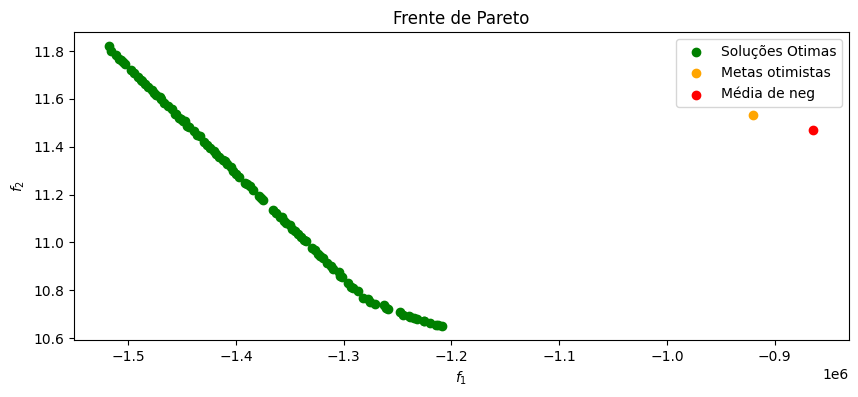

In [52]:
frente_pareto(res_f, df.media_cenario, df.media, df.frequencia, df.valor_otimo)